<a href="https://colab.research.google.com/github/FrancoNMarquez/CHAT-LEF/blob/master/TF_Conectar_CHATLEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hacer consultas , trae los vectores almacenado en Pienecone y hace consultas**

In [4]:
!pip install openai -q
!pip install langchain -q
!pip install tiktoken -q
!pip install pinecone-client -q
!pip install python-dotenv -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.4/246.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 4.7 MB/s eta 0:00:00


In [5]:
# Montar Google Drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
 # Carga OPENAI_API_KEY
from dotenv import load_dotenv, find_dotenv
load_dotenv('/content/drive/MyDrive/Archivos/NLP/.env')

True

In [7]:
# Conectarse con Pinecone
from pinecone import Pinecone, PodSpec
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Pinecone

In [ ]:
model_name = 'text-embedding-ada-002'
OPENAI_API_KEY=os.environ.get("OPENAI_API_KEY")
indice="videos"
embedding= OpenAIEmbeddings(
    model=model_name,
    openai_api_key=OPENAI_API_KEY
)

In [9]:
# Cargo el los vectores desde Pienecone
vector_store=Pinecone.from_existing_index(indice,embedding)

In [10]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI

In [ ]:
# Convocamos el modelo LLM cpn Chain
llm=ChatOpenAI(model="gpt-3.5-turbo",temperature=1)
retriever=vector_store.as_retriever(search_type="similarity",search_kwargs={"k":3})
chain=RetrievalQA.from_chain_type(llm=llm,chain_type="stuff",retriever=retriever) # para ejecutar la busqueda

**Agregamos memoria**, para hacer repreguntas para que tengamos un hilo conductor

In [40]:
# agregamos memoria para hacerlo conversasional
from langchain.chains import ConversationalRetrievalChain  # lo usamos para hacer una convesasion parecida a chat gpt
from langchain.chat_models import ChatOpenAI

llm=ChatOpenAI(model="gpt-3.5-turbo",temperature=1)
retriever=vector_store.as_retriever(search_type="similarity",search_kwargs={"k":3}) # modelo de recuperacion de la consulta
crc=ConversationalRetrievalChain.from_llm(llm=llm,retriever=retriever)
memoria=[]

**Interface** para chatear con chatlef

In [53]:
## Ejecutamos la consulta en el la interface
import ipywidgets as widgets
from IPython.display import display

# Crear widgets
respuesta_texto = widgets.Textarea(disabled=True, layout={'width': '80%', 'height': '250px'})
#respuesta_texto = widgets.Textarea(disabled=True, layout={'width': '80%', 'height': '100px'})

pregunta_texto = widgets.Text(placeholder='Escribe tu pregunta...', layout={'width': '50%'})
boton_enviar = widgets.Button(description='Enviar', layout={'width': '10%'})

# Lista para almacenar la conversación
conversacion = []

# Función para manejar el evento de clic en el botón de enviar
def enviar_pregunta(b):
    pregunta = pregunta_texto.value
    # Procesar la pregunta y obtener la respuesta
    #respuesta = chain.run(pregunta) #  REspuesta simple

    respuesta=crc({"question":pregunta,"chat_history":memoria}) ## Respuesta convesacional
    memoria.append((pregunta,respuesta["answer"])) ## Respuesta convesacional
    respuesta=respuesta["answer"]
    # Agregar la pregunta y la respuesta a la conversación
    conversacion.append(f"Tú: {pregunta}\nAsistente: {respuesta}")

    # Actualizar el texto de la conversación
    respuesta_texto.value = '\n\n'.join(conversacion)

    # Limpiar el cuadro de texto de la pregunta
    pregunta_texto.value = ""

# Asignar la función enviar_pregunta al evento on_click del botón de enviar
boton_enviar.on_click(enviar_pregunta)

# Mostrar los widgets

contenedor_pregunta_enviar = widgets.HBox([pregunta_texto, boton_enviar]) # Coloca el boton al lado derecho de la pregunta

display(respuesta_texto)
display(contenedor_pregunta_enviar)




Textarea(value='', disabled=True, layout=Layout(height='250px', width='80%'))

**Dede Audio** falta desarrollar

In [ ]:
!pip install git+https://github.com/m-bain/whisperx.git --upgrade

In [ ]:
import whisperx

device = "cuda"
batch_size = 16
compute_type = "float16"

In [ ]:
# Cargamos el modelo
model = whisperx.load_model("large-v2", device, compute_type=compute_type)

In [ ]:
audio1 = whisperx.load_audio(audio)

In [ ]:
result = model.transcribe(audio1, batch_size=batch_size)
preg1=result["segments"][0]["text"]
print (preg1)

**Graba audio directamente desde el colab**

**Grabar audio desde colab **  (funciona correctamente, problema con la exportacion del audio)

In [3]:
!pip install ffmpeg-python


In [4]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>

"""
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [6]:
audio, sr = get_audio()




In [11]:
import matplotlib.pyplot as plt

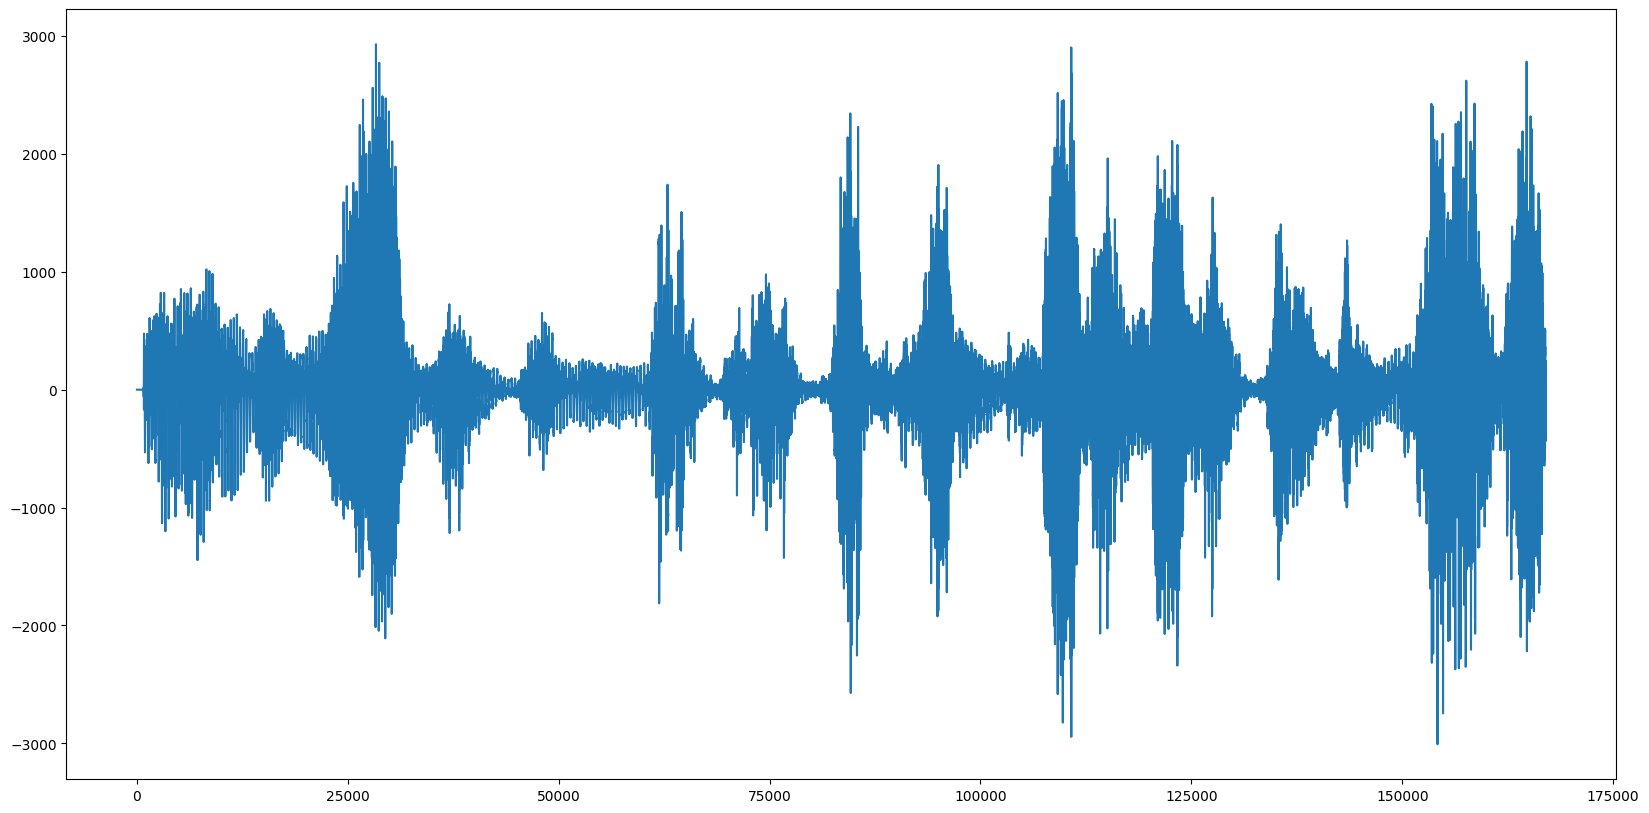

In [12]:
plt.figure(figsize=(20,10))
plt.plot(audio)
plt.show()

In [9]:
len(audio)

167040